In [1]:
import os
import sys
sys.path.append("../")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import qmc, norm
from sklearn.linear_model import LinearRegression
import linearmodels
from linearmodels import PooledOLS, PanelOLS, RandomEffects
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from custom_models import SigmoidPooledOLS

%load_ext autoreload
%autoreload 2

# Выгрузка и анализ данных

In [2]:
df_train = pd.read_csv('data/df_train.csv', index_col=0)
df_test = pd.read_csv('data/df_test.csv', index_col=0)

In [3]:
df_train.head()

,id,date,value,label,newtime,year,month
0,19114,2016-01-01,-1.86,0.0,2016-01-01,2016,1
1,19114,2016-02-01,0.79,0.0,2016-02-01,2016,2
2,19114,2016-03-01,1.40,0.0,2016-03-01,2016,3
3,19114,2016-04-01,0.15,0.0,2016-04-01,2016,4
4,19114,2016-05-01,0.00,0.0,2016-05-01,2016,5


In [4]:
df_test.head()

,id,date,value,newtime,year,month
0,6125,2016-01-01,1.85,2016-01-01,2016,1
1,6125,2016-02-01,-0.04,2016-02-01,2016,2
2,6125,2016-03-01,0.19,2016-03-01,2016,3
3,6125,2016-04-01,-0.45,2016-04-01,2016,4
4,6125,2016-05-01,-0.75,2016-05-01,2016,5


тут рассказать про предобработку 

In [5]:
df_train.shape

(5150830, 7)

In [6]:
df_test.shape

(1286952, 6)

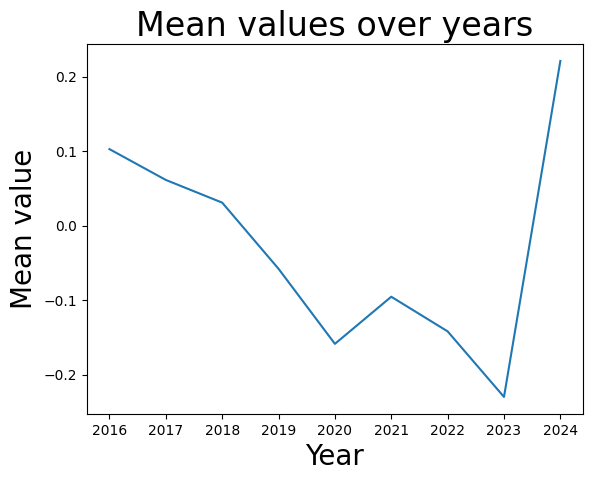

In [7]:
mean_value = df_train.groupby('year')['value'].mean()
mean_value  = mean_value.to_frame()

sns.lineplot(x='year', y='value', data=mean_value)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Mean value", fontsize=20)
plt.title("Mean values over years", fontsize=24)
plt.show()

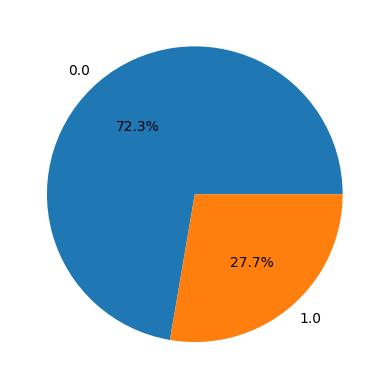

In [8]:
data_for_graph = df_train.drop_duplicates(subset='id')['label'].value_counts()
plt.pie(data_for_graph, labels=data_for_graph.index, autopct='%1.1f%%');

In [9]:
unique_counts = df_train.nunique()
print(unique_counts)

id          79912
date           97
value      243743
label           2
newtime        97
year            9
month          12
dtype: int64


# Подготовка к построению моделей 

# разделяем обучающую выборку 

In [10]:
df_train.head()

,id,date,value,label,newtime,year,month
0,19114,2016-01-01,-1.86,0.0,2016-01-01,2016,1
1,19114,2016-02-01,0.79,0.0,2016-02-01,2016,2
2,19114,2016-03-01,1.40,0.0,2016-03-01,2016,3
3,19114,2016-04-01,0.15,0.0,2016-04-01,2016,4
4,19114,2016-05-01,0.00,0.0,2016-05-01,2016,5


In [11]:
df_train.shape

(5150830, 7)

In [12]:
df_train['newtime'] = pd.to_datetime(df_train['newtime'])

In [13]:
from panelsplit import PanelSplit

# Initialize PanelSplit with your panel data's time periods
panel_split = PanelSplit(periods=df_train['newtime'], n_splits=2, test_size = 40)

# Generate splits
for train_idx, valid_idx in panel_split.split():
    train_set = df_train.iloc[train_idx]
    valid_set = df_train.iloc[valid_idx]
    # Train your model on train_set and validate on test_set

In [14]:
train_set.shape

(3998069, 7)

In [15]:
valid_set.shape

(1152761, 7)

In [16]:
train_set.set_index(['id', 'newtime'], inplace=True)

In [17]:
valid_set.set_index(['id', 'newtime'], inplace=True)

In [18]:
train_set

date    value  label  year  month
id    newtime                                            
19114 2016-01-01  2016-01-01 -1.86000    0.0  2016      1
      2016-02-01  2016-02-01  0.79000    0.0  2016      2
      2016-03-01  2016-03-01  1.40000    0.0  2016      3
      2016-04-01  2016-04-01  0.15000    0.0  2016      4
      2016-05-01  2016-05-01  0.00000    0.0  2016      5
...                      ...      ...    ...   ...    ...
98870 2019-11-01  2019-11-01  1.40335    1.0  2019     11
      2019-12-01  2019-12-01  0.26335    1.0  2019     12
      2020-01-01  2020-01-01 -1.73665    1.0  2020      1
      2020-02-01  2020-02-01 -0.38665    1.0  2020      2
      2020-03-01  2020-03-01 -1.72665    1.0  2020      3

[3998069 rows x 5 columns]

In [19]:
train_set.reset_index().dtypes

id                  int64
newtime    datetime64[ns]
date               object
value             float64
label             float64
year                int64
month               int64
dtype: object

In [20]:
# pooled ols without const
model_pooled = PooledOLS(dependent=train_set['label'], exog=train_set['value'])
fitted_model = model_pooled.fit()

In [21]:
fitted_model.predict(valid_set['value'])

predictions
id    newtime                
19114 2020-10-01     0.001267
      2020-11-01    -0.004026
      2020-12-01    -0.001583
      2021-01-01     0.002307
      2021-02-01     0.002578
...                       ...
94731 2020-12-01    -0.005745
      2021-01-01    -0.009590
      2021-02-01    -0.004524
      2021-03-01    -0.002714
      2021-04-01    -0.003031

[1152761 rows x 1 columns]

In [22]:
train_set[train_set['label'] == 1]

date    value  label  year  month
id    newtime                                            
22769 2016-05-01  2016-05-01 -1.04000    1.0  2016      5
      2016-06-01  2016-06-01 -3.48000    1.0  2016      6
      2016-07-01  2016-07-01  0.05000    1.0  2016      7
      2016-08-01  2016-08-01 -0.13000    1.0  2016      8
      2016-09-01  2016-09-01 -0.01000    1.0  2016      9
...                      ...      ...    ...   ...    ...
98870 2019-11-01  2019-11-01  1.40335    1.0  2019     11
      2019-12-01  2019-12-01  0.26335    1.0  2019     12
      2020-01-01  2020-01-01 -1.73665    1.0  2020      1
      2020-02-01  2020-02-01 -0.38665    1.0  2020      2
      2020-03-01  2020-03-01 -1.72665    1.0  2020      3

[1109413 rows x 5 columns]

In [23]:
fixed_ols = SigmoidPooledOLS(PanelOLS)
fixed_ols.fit(
    train_set['value'], train_set['label'], 
    **{'time_effects': True})

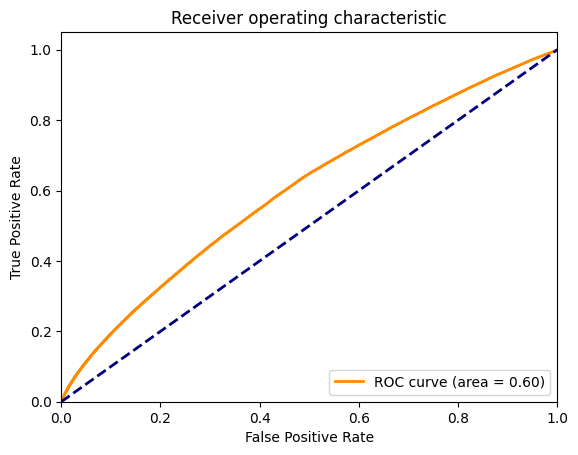

0.6026067314369361


In [24]:
predictions_valid = fixed_ols.predict(valid_set['value'])
print(fixed_ols.evaluate(valid_set['label'], predictions_valid))